In [1]:
import rank
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter
import numpy as np
import cv2

In [ ]:
#query_path = 'datasets/Brueghel/Winter Village Landscape with Ice Skating.jpg'
#query_path = 'datasets/Brueghel/Wide Landscape with Wagon and Travelers (London).jpg'
#query_path = 'datasets/Brueghel/Winter (Braunschweig).jpg'
#query_path = '/home/annab/Durham2024/datasets/Brueghel/A Bridal Feast (Unknown).jpg'
query_path = 'datasets/Brueghel/Wide River Landscape with Resting Travelers.jpg' ##INTERSTING#
#query_path = 'datasets/Brueghel/Allegory of Air (Germany).jpg'
#query_path = 'datasets/Brueghel/Wedding Celebration in a Barn (Sotheby\'s, London 2002).jpg'
#query_path = 'datasets/Brueghel/Village Street with Dancing Peasants.jpg'
#query_path = 'datasets/Brueghel/View Down a River through a Village.jpg'
top_matches = rank.cos_sim(query_path, 'embeddings/Brueghel_conc.pkl')

In [ ]:
for query, matches in top_matches:
   print(query)
   #print(f"Query: {query['box']}")
   for match, similarity in matches:
       print(f"Match: {match['image_path'], match['box']} with similarity {similarity}")


In [2]:
import rank
top_matches = rank.rank_local_to_global('embeddings/Brueghel_query/resnet50_conc_pca_50.pkl', 'embeddings/Brueghel/resnet50_conc_pca_50.pkl', 30)
#print(top_matches)

for q in top_matches[:1]:
    for m in q:
        print(m[0]['image_path'], m[1])

(146, 36186)
datasets/Brueghel/Wedding Procession to a Church (Brussels).jpg 0.752329814798746
datasets/Brueghel/A Bridal Procession (Brussels).jpg 0.7234679728073874
datasets/Brueghel/Wedding Procession with Windmill (Dorotheum, Vienna, 2000).jpg 0.691701517027635
datasets/Brueghel/St. Martin Dividing His Cloak (London).jpg 0.6688104647207758
datasets/Brueghel/A Bridal Procession (unknown).jpg 0.6518035822706111
datasets/Brueghel/Peasant Wedding Procession (Sotheby's, London, 1973).jpg 0.640973836787874
datasets/Brueghel/Broad Landscape with Windmills.jpg 0.6241530349021236
datasets/Brueghel/A Bridal Procession (Paris).jpg 0.6227301490149633
datasets/Brueghel/Landscape with Windmill and Bridal Procession (Christie's, London, 1999).jpg 0.6215303656759373
datasets/Brueghel/A Bridal Procession (Dorotheum, Vienna, 2004).jpg 0.6028537941886254
datasets/Brueghel/Resting at the Windmill.jpg 0.6023333214519889
datasets/Brueghel/The Wedding Procession (Sotheby, Monaco, 1989).jpg 0.600636453862

In [7]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter
import numpy as np

def draw_bounding_boxes(image_path, boxes, colors, tags = None, alpha=0, offset=2):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = image.shape
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.imshow(image)
    ax.axis('off')

    offsets = np.zeros((len(boxes), 2))  # Array to keep track of offsets applied to each box

    for i, (x1, y1, x2, y2) in enumerate(boxes):
        x1 = int(x1 * width)
        y1 = int(y1 * height)
        x2 = int(x2 * width)
        y2 = int(y2 * height)

        # Apply an offset if this box overlaps with previously drawn boxes
        for j in range(i):
            prev_x1, prev_y1, prev_x2, prev_y2 = boxes[j]
            prev_x1 = int(prev_x1 * width) + offsets[j][0]
            prev_y1 = int(prev_y1 * height) + offsets[j][1]
            prev_x2 = int(prev_x2 * width) + offsets[j][0]
            prev_y2 = int(prev_y2 * height) + offsets[j][1]

            # Check for overlap
            if (x1 < prev_x2 and x2 > prev_x1 and y1 < prev_y2 and y2 > prev_y1):
                offsets[i] = [offsets[i][0] + offset, offsets[i][1] + offset]
        
        x1 += offsets[i][0]
        y1 += offsets[i][1]
        x2 += offsets[i][0]
        y2 += offsets[i][1]

        # Draw the bounding boxes
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=2, edgecolor=colors[i], facecolor='none',
            alpha=0.8
        )
        ax.add_patch(rect)
        
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=2, edgecolor='none', facecolor=colors[i],
            alpha=alpha
        )
        ax.add_patch(rect)

        if tags is not None:
            ax.text(
                x1, y1 - 10, f'{tags[i]}', 
                color='white', fontsize=8, 
                bbox=dict(facecolor='black', alpha=0.4, pad=1)
            )

    plt.tight_layout()
    plt.show()

def most_matched_images(top_matches, n_images, n_boxes):
    query_path = top_matches[0][0]['image_path']
    
    counter = Counter()
    for _, matches in top_matches:
        for match_embedding_dict, _ in matches:
            counter[match_embedding_dict['image_path']] += 1

    most_common_image_paths = counter.most_common(n_images)
    print('Top matches:', most_common_image_paths)

    top_matches_on_most_common_images = []
    
    for img_path, _ in most_common_image_paths:
        matches_for_img = []
        for query_embedding_dict, matches in top_matches:
            for match_embedding_dict, similarity in matches:
                if match_embedding_dict['image_path'] == img_path:
                    matches_for_img.append((query_embedding_dict, match_embedding_dict, similarity))
        
        matches_for_img.sort(key=lambda x: x[2], reverse=True)
        top_matches_on_most_common_images.append(matches_for_img[:n_boxes])
    
    for matches in top_matches_on_most_common_images:
        query_boxes = [match[0]['box'] for match in matches]
        match_boxes = [match[1]['box'] for match in matches]
        similarities = [match[2] for match in matches]

        print(similarities)

        tags = [i for i in range(1, 100)]
        
        cmap = plt.get_cmap('coolwarm')
        colors = [cmap(similarity) for similarity in similarities]



        
        if matches:
            image_path = matches[0][1]['image_path']
            draw_bounding_boxes(query_path, query_boxes, colors, offset=5, tags = tags)
            draw_bounding_boxes(image_path, match_boxes, colors, offset=5, tags = tags)


Top matches: [('datasets/Brueghel/Allegory of Air (Lyon).jpg', 100), ('datasets/Brueghel/Allegory of Air (Paris).jpg', 45), ('datasets/Brueghel/Allegory of Air (Rome).jpg', 30)]
[0.9156492183355422, 0.8621848741475784, 0.8575272012673795, 0.8532448713172253, 0.8408269586959012, 0.8388924571953, 0.8331382901120858, 0.8269354557985403, 0.825406556464591, 0.8243290151914582]


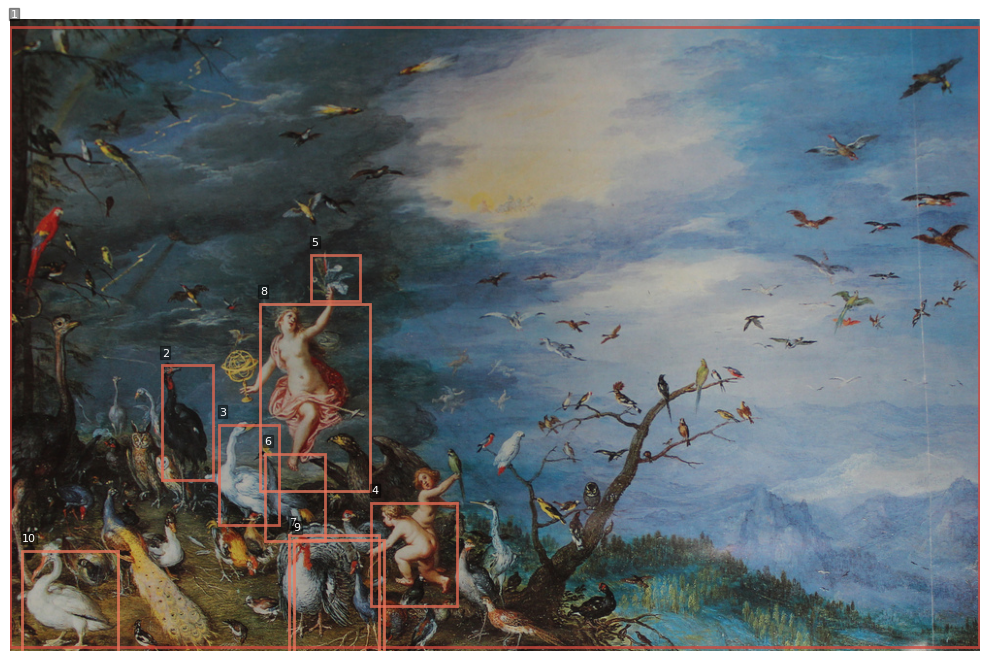

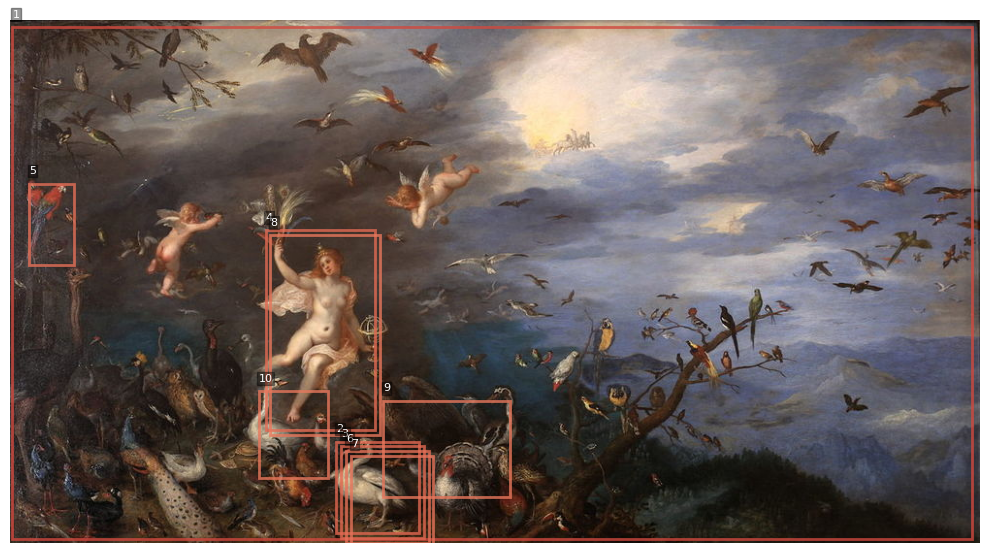

[0.8684406678833348, 0.8026916286054074, 0.7986562765940713, 0.7955645165868191, 0.7871790548015845, 0.7869101110773388, 0.7868679097707225, 0.7857476863170363, 0.7853308985581238, 0.7816748514205007]


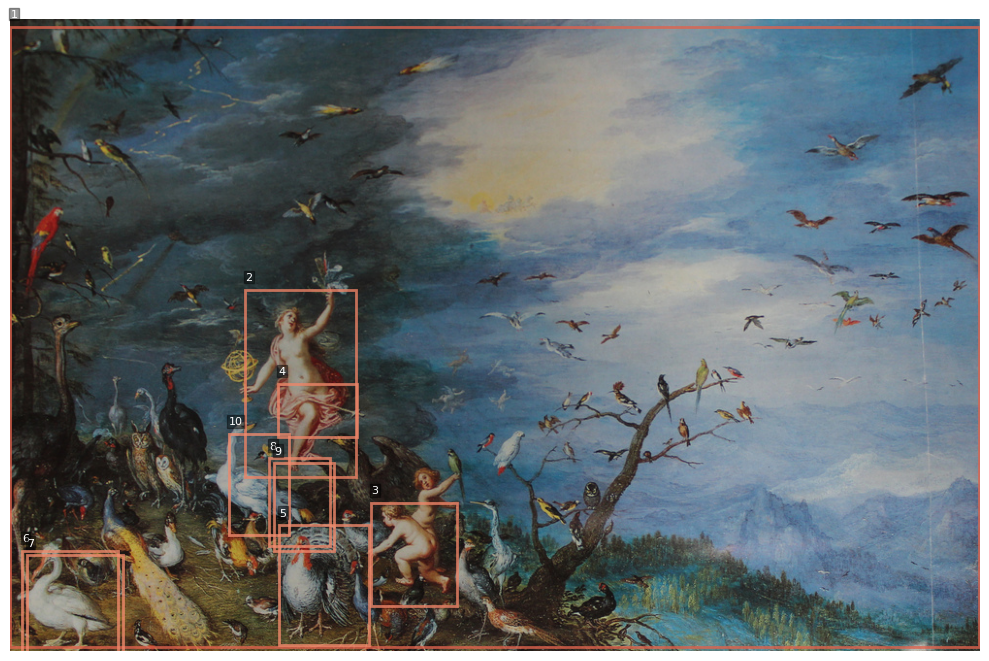

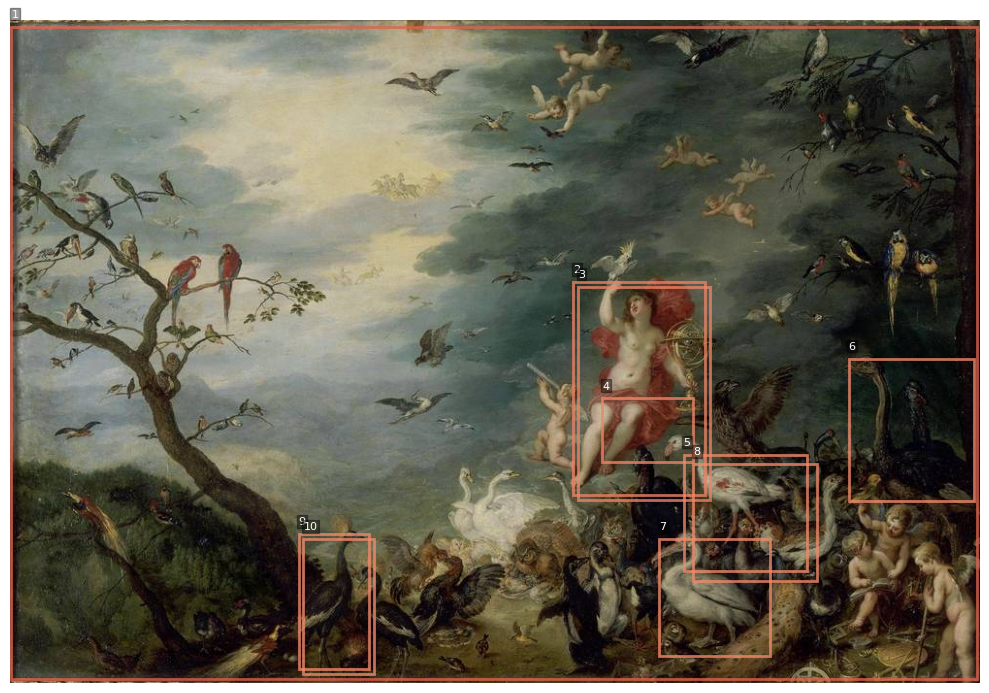

[0.8759786107498597, 0.8169498735515737, 0.8038140672547974, 0.7988671712383724, 0.790277195015524, 0.7849472788599031, 0.7802145818903949, 0.7736626293426786, 0.7707838294562878, 0.769501655563348]


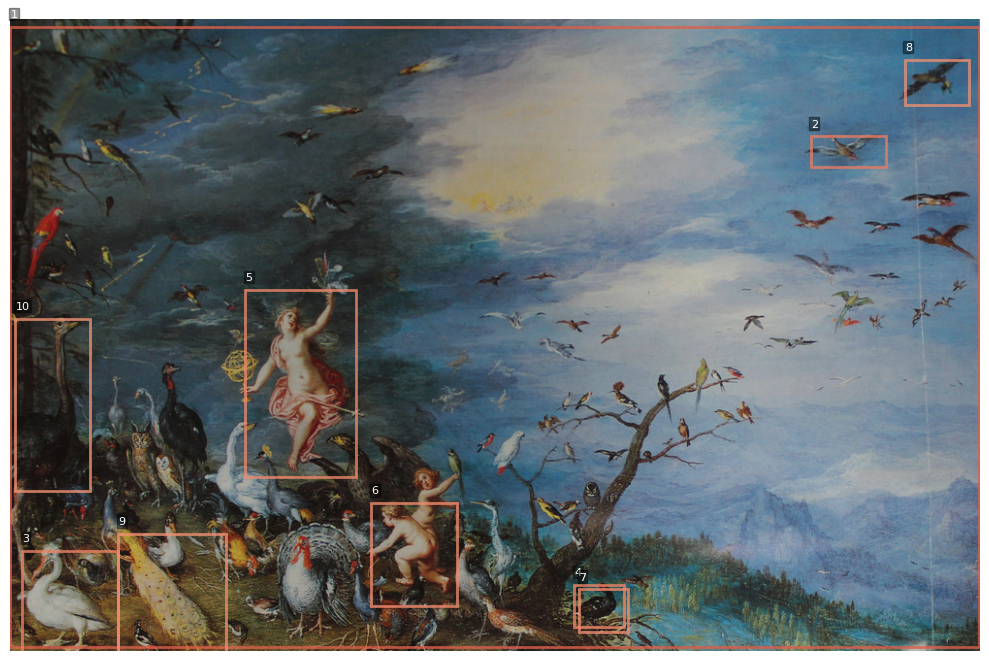

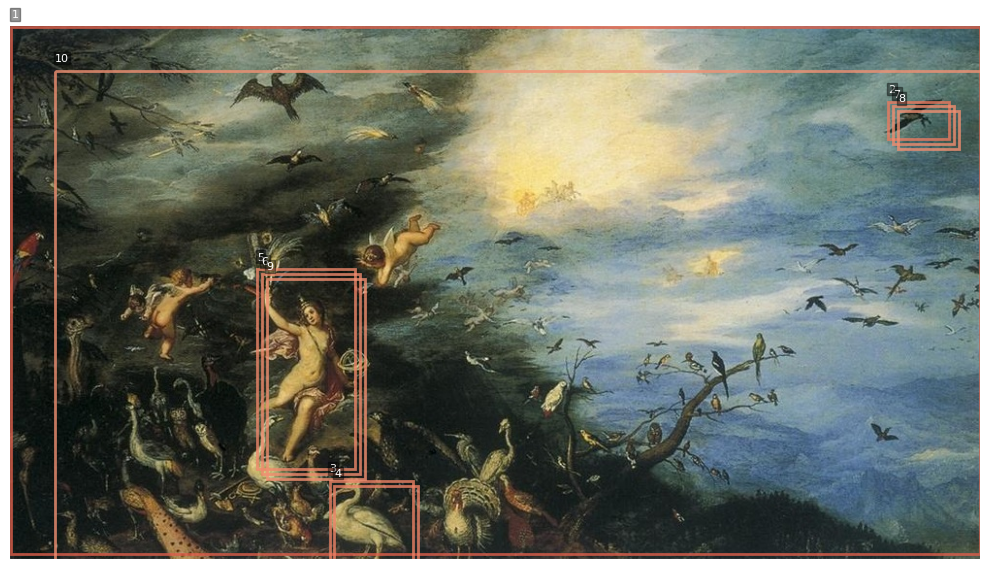

In [8]:
most_matched_images(top_matches, 3, 10)

In [2]:
query_path  = "datasets/Brueghel/A Bridal Procession (Antwerp).jpg"
image = cv2.imread(query_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
height, width, _ = image.shape

# Define the bounding box
box = [409, 37, 544, 271]

# Convert box coordinates to ratios
x_min, y_min, x_max, y_max = box

x_min_ratio = x_min / width
y_min_ratio = y_min / height
x_max_ratio = x_max / width
y_max_ratio = y_max / height

box = (x_min_ratio, y_min_ratio, x_max_ratio, y_max_ratio)
top_matches = rank.cos_sim(query_path, 'embeddings/Brueghel_conc.pkl', patch_box=box)




ValueError: n_components=50 must be between 0 and min(n_samples, n_features)=1 with svd_solver='full'

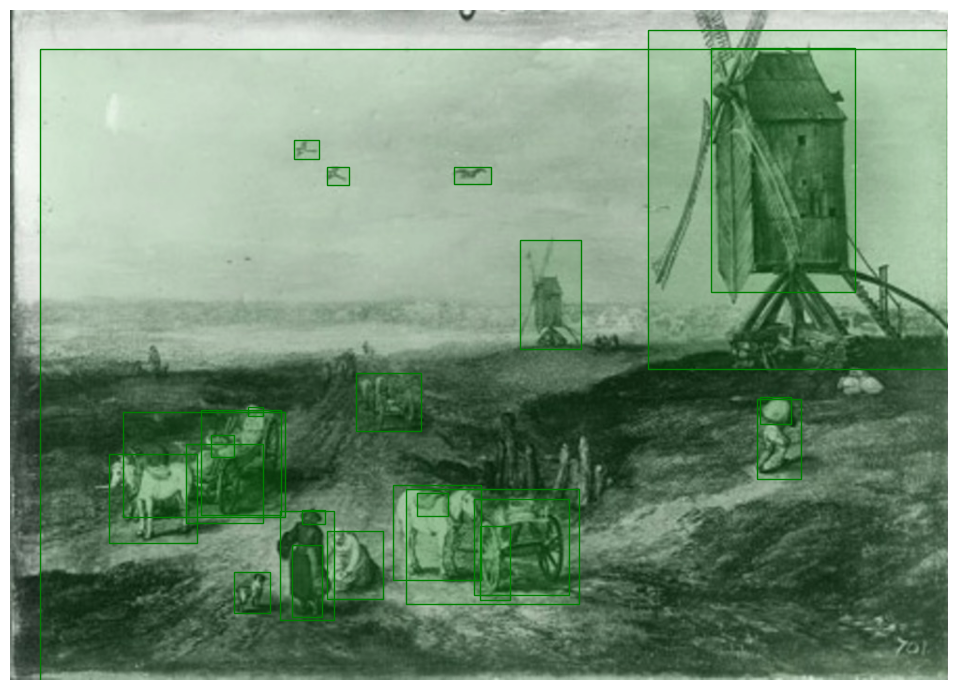

In [8]:
import json
with open('object_detection/brueg_small_detections/Windmill in a Broad Field.json', 'r') as f:
  data = json.load(f)
boxes = [item['box'] for item in data] 
t_boxes = [(b['x1'], b['y1'], b['x2'], b['y2']) for b in boxes]

colors = []

for i in range(50):
  colors.append('green')

draw_bounding_boxes('datasets/brueg_small/Windmill in a Broad Field.jpg', t_boxes, colors )